### Loading Data

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import SpectralClustering
from scipy.spatial import ConvexHull
import plotly.express as px
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, rand_score
from scipy.stats import multivariate_normal
from pandas.plotting import parallel_coordinates


In [ ]:
df = pd.read_csv('6156538.txt', header=None, names=features, sep=" ", index_col=0)

In [ ]:
df

,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,palvic_radius,spondylolisthesis_grade,patient_status
pelvic_incidence,,,,,,
63.03,22.55,39.61,40.48,98.67,-0.25,AB
39.06,10.06,25.02,29.00,114.41,4.56,AB
68.83,22.22,50.09,46.61,105.99,-3.53,AB
69.30,24.65,44.31,44.64,101.87,11.21,AB
49.71,9.65,28.32,40.06,108.17,7.92,AB
...,...,...,...,...,...,...
47.90,13.62,36.00,34.29,117.45,-4.25,NO
53.94,20.72,29.22,33.22,114.37,-0.42,NO
61.45,22.69,46.17,38.75,125.67,-2.71,NO


In [ ]:
df.to_csv('processed.csv')

### EDA

In [ ]:
processed_df = pd.read_csv('processed.csv')

In [ ]:
processed_df

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,palvic_radius,spondylolisthesis_grade,patient_status
0,63.03,22.55,39.61,40.48,98.67,-0.25,AB
1,39.06,10.06,25.02,29.00,114.41,4.56,AB
2,68.83,22.22,50.09,46.61,105.99,-3.53,AB
3,69.30,24.65,44.31,44.64,101.87,11.21,AB
4,49.71,9.65,28.32,40.06,108.17,7.92,AB
...,...,...,...,...,...,...,...
305,47.90,13.62,36.00,34.29,117.45,-4.25,NO
306,53.94,20.72,29.22,33.22,114.37,-0.42,NO
307,61.45,22.69,46.17,38.75,125.67,-2.71,NO
308,45.25,8.69,41.58,36.56,118.55,0.21,NO


In [ ]:
processed_df.isnull().sum()

,0
pelvic_incidence,0
pelvic_tilt,0
lumbar_lordosis_angle,0
sacral_slope,0
palvic_radius,0
spondylolisthesis_grade,0
patient_status,0


In [ ]:
processed_df.duplicated().sum()

0

#### Distribution of Class Labels

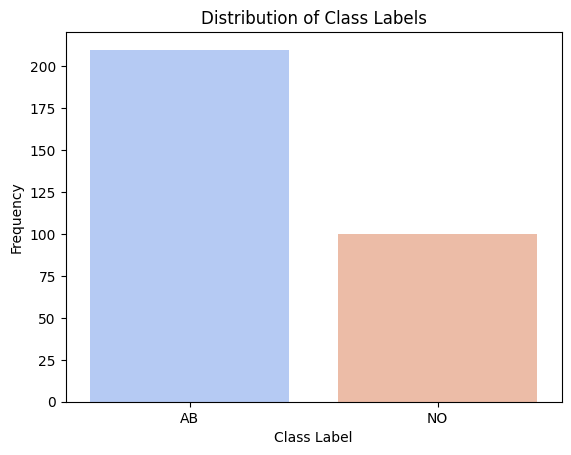

In [ ]:
sns.barplot(x=df['patient_status'].value_counts().index,
            y=df['patient_status'].value_counts().values,
            hue=df['patient_status'].value_counts().index,
            palette='coolwarm',
            legend=False)
plt.xlabel('Class Label')
plt.ylabel('Frequency')
plt.title('Distribution of Class Labels')
plt.show()

#### Boxplots of Features

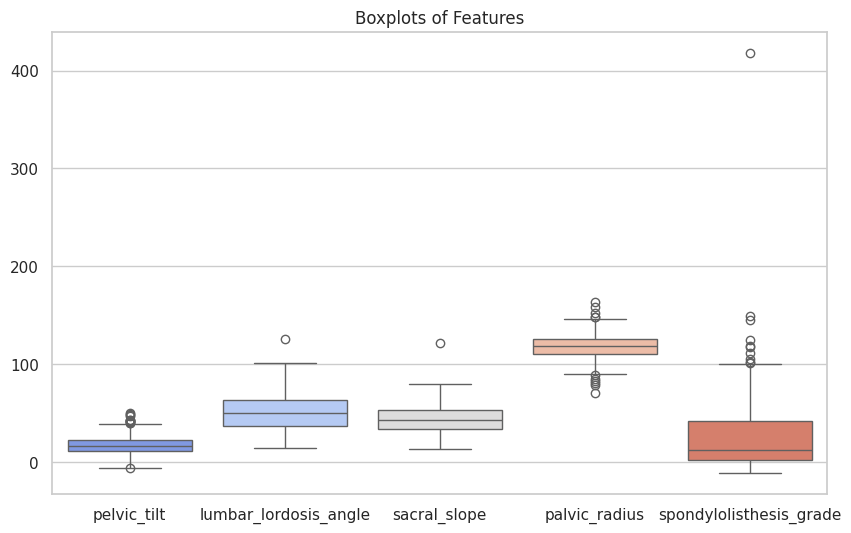

In [ ]:
plt.figure(figsize=(10, 6))
sns.set(style='whitegrid')
sns.boxplot(data=df.drop('patient_status', axis=1, inplace=False), palette='coolwarm')
plt.title('Boxplots of Features')
plt.show()

#### Distribution of Features

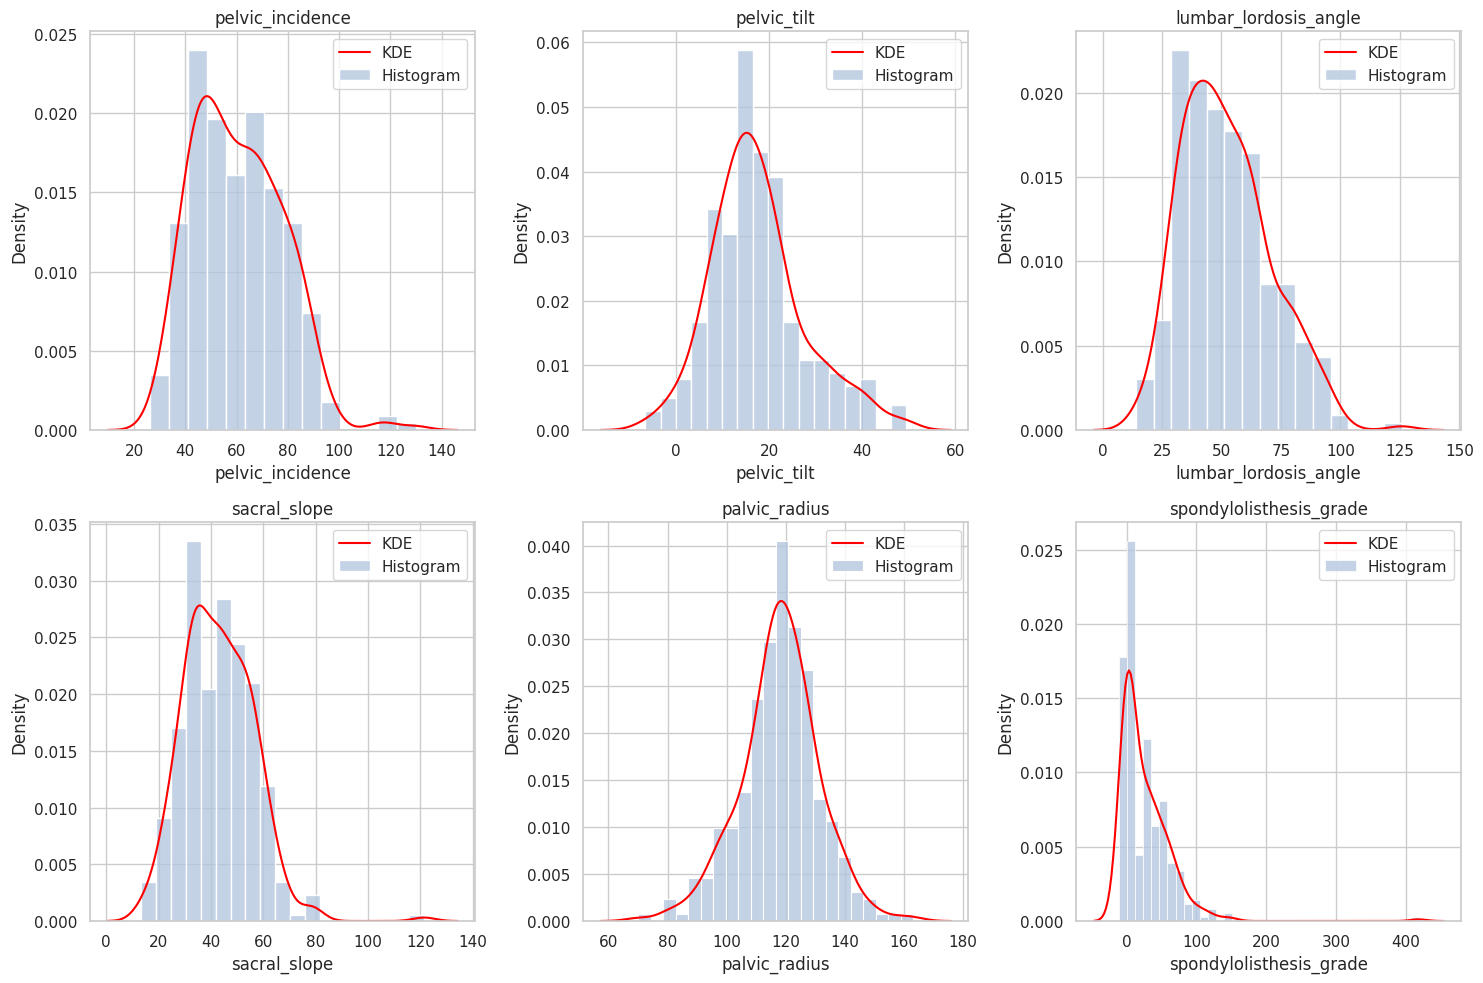

In [ ]:
# Define number of columns to plot
num_columns = len(processed_df.columns)  # Count actual columns
nrows, ncols = 2, 3  # Adjust as needed

# Ensure the subplot grid is large enough
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 10))
axes = axes.flatten()  # Flatten to handle indexing properly

# Iterate over only the available columns
for i, column in enumerate(processed_df.columns):
    if i < len(axes):  # Avoid IndexError
        sns.kdeplot(processed_df[column], color='red', label='KDE', ax=axes[i])
        sns.histplot(processed_df[column], stat='density', color='lightsteelblue', label='Histogram', ax=axes[i])
        axes[i].set_title(column)
        axes[i].legend()

# Hide unused subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [ ]:
processed_df.isna().sum()

,0
pelvic_incidence,0
pelvic_tilt,0
lumbar_lordosis_angle,0
sacral_slope,0
palvic_radius,0
spondylolisthesis_grade,0
patient_status,0


#### VIF

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
X = processed_df.select_dtypes(include=[np.number])
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values,i) for i in range (X.shape[1])]
print(vif_data)

                   Feature           VIF
0         pelvic_incidence  1.385993e+08
1              pelvic_tilt  1.428048e+07
2    lumbar_lordosis_angle  1.889246e+01
3             sacral_slope  7.093679e+07
4            palvic_radius  1.230600e+01
5  spondylolisthesis_grade  2.364359e+00


#### Correlation Matrix

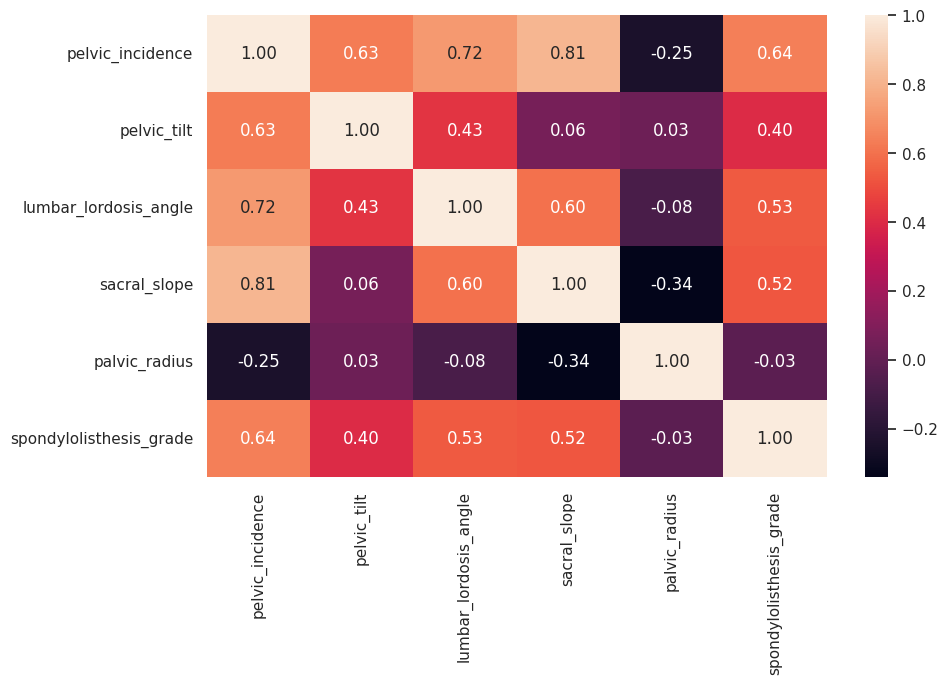

In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(processed_df.drop(columns=['patient_status']).corr(), annot=True, fmt='.2f')
plt.show()

In [ ]:
print(processed_df.drop(columns=['patient_status']).corr(method='spearman'))

                         pelvic_incidence  pelvic_tilt  lumbar_lordosis_angle  \
pelvic_incidence                 1.000000     0.653150               0.778435   
pelvic_tilt                      0.653150     1.000000               0.418514   
lumbar_lordosis_angle            0.778435     0.418514               1.000000   
sacral_slope                     0.800709     0.123878               0.692864   
palvic_radius                   -0.266644    -0.006941              -0.134283   
spondylolisthesis_grade          0.670836     0.396747               0.683634   

                         sacral_slope  palvic_radius  spondylolisthesis_grade  
pelvic_incidence             0.800709      -0.266644                 0.670836  
pelvic_tilt                  0.123878      -0.006941                 0.396747  
lumbar_lordosis_angle        0.692864      -0.134283                 0.683634  
sacral_slope                 1.000000      -0.365484                 0.532862  
palvic_radius               -0.3

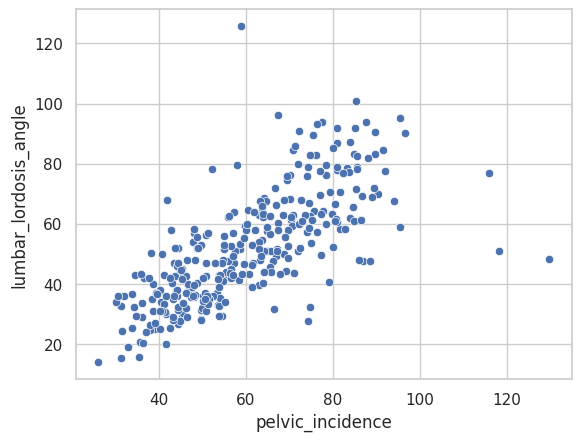

In [ ]:
sns.scatterplot(x=processed_df['pelvic_incidence'], y=processed_df['lumbar_lordosis_angle'])
plt.show()

#### Parallel Coordinates Plot

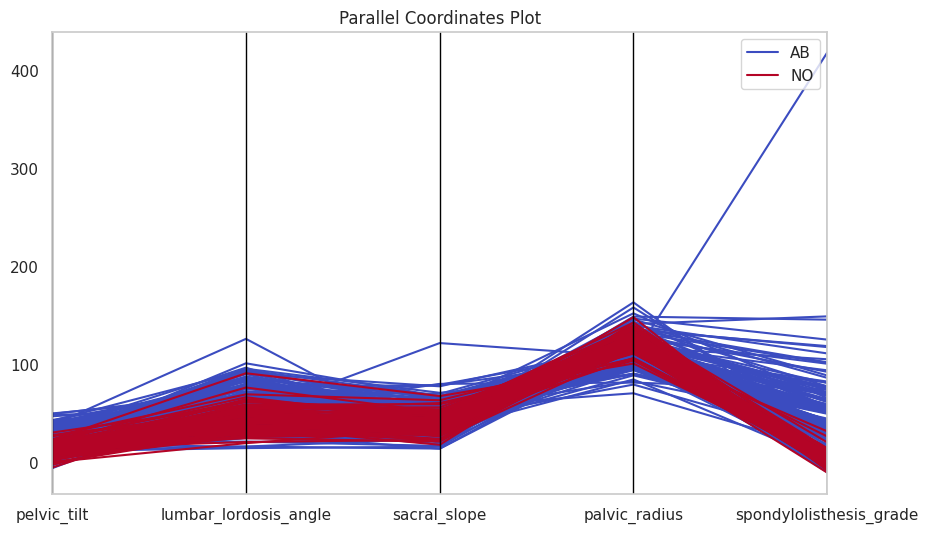

In [ ]:
plt.figure(figsize=(10, 6))
parallel_coordinates(df, 'patient_status', colormap='coolwarm')
plt.title('Parallel Coordinates Plot')
plt.show()

### Data Preprocessing

#### Feature Selection - Removed pelvic incidence

In [ ]:
processed_df.drop(columns=["pelvic_incidence"],inplace=True)

In [ ]:
processed_df

,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,palvic_radius,spondylolisthesis_grade,patient_status
0,22.55,39.61,40.48,98.67,-0.25,AB
1,10.06,25.02,29.00,114.41,4.56,AB
2,22.22,50.09,46.61,105.99,-3.53,AB
3,24.65,44.31,44.64,101.87,11.21,AB
4,9.65,28.32,40.06,108.17,7.92,AB
...,...,...,...,...,...,...
305,13.62,36.00,34.29,117.45,-4.25,NO
306,20.72,29.22,33.22,114.37,-0.42,NO
307,22.69,46.17,38.75,125.67,-2.71,NO
308,8.69,41.58,36.56,118.55,0.21,NO


#### Handle Outliers

In [ ]:
def remove_outliers_iqr(data, features):
    """
    Removes outliers from the dataset using the IQR method for the given features.
    """
    Q1 = data[features].quantile(0.25)
    Q3 = data[features].quantile(0.75)
    IQR = Q3 - Q1

    # lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    mask = ~((data[features] < lower_bound) | (data[features] > upper_bound)).any(axis=1)
    return data[mask]

In [ ]:
processed_df['patient_status'] = processed_df.loc[processed_df.index, 'patient_status']

In [ ]:
processed_df.columns[:-1]

Index(['pelvic_tilt', 'lumbar_lordosis_angle', 'sacral_slope', 'palvic_radius',
       'spondylolisthesis_grade'],
      dtype='object')

### Unsupervised Learning

#### Finding the Optimal K

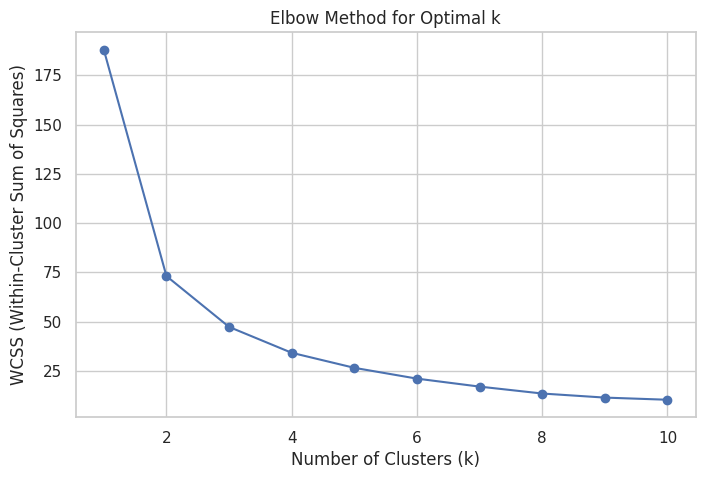

In [ ]:
# These are the pca features and the target (patient status)
pca_features = processed_df.columns[:-1]
target = processed_df.columns[-1]

# removal of outliers using the method developed
processed_df_cleaned = remove_outliers_iqr(processed_df, pca_features)

# taking the numerical features only
X_cleaned = processed_df_cleaned[pca_features]

# standardize for PCA
scaler = StandardScaler()
X_kpca_scaled = scaler.fit_transform(X_cleaned[pca_features])

# KernelPCA with cosine Kernel
kpca = KernelPCA(n_components=2, kernel='cosine')
X_kpca = kpca.fit_transform(X_kpca_scaled)
X_kpca_df = pd.DataFrame(X_kpca, columns=['KPCA1', 'KPCA2'])

# elbow method to see which number of clusters performs best
wcss = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_kpca_df)
    wcss.append(kmeans.inertia_)

# Elbow curve method
plt.figure(figsize=(8, 5))
plt.plot(K_range, wcss, marker='o', linestyle='-')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("WCSS (Within-Cluster Sum of Squares)")
plt.title("Elbow Method for Optimal k")
plt.show()



#### KMeans -> PCA

THIS VARIANCE VALUE SHOWS THAT THESE COMPONENTS ARE SOMEWHAT REPRESENTATIVE!:  [0.53429648 0.21783625 0.14600595]


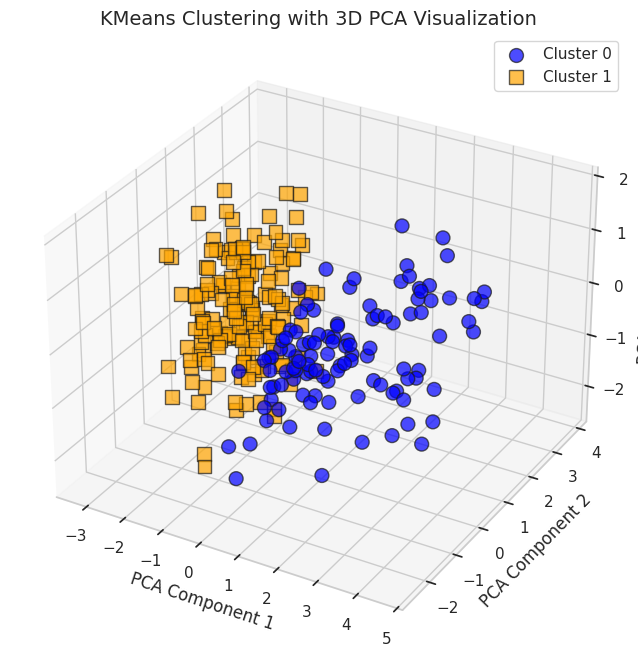

In [ ]:
# Step 1: Standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cleaned)  # Standardize input features

# Step 2: Apply KMeans Clustering (Normal KMeans)
optimal_k = 2  # Set based on elbow method
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=100)
clusters = kmeans.fit_predict(X_scaled)  # Cluster in original space

# Step 3: PCA Transformation (3D PCA for visualization)
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)  # Apply PCA AFTER KMeans
print("THIS VARIANCE VALUE SHOWS THAT THESE COMPONENTS ARE SOMEWHAT REPRESENTATIVE!: ", pca.explained_variance_ratio_)

# Convert to DataFrame
X_pca_df = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2', 'PCA3'])
X_pca_df['Cluster'] = clusters  # Add cluster labels

# Step 4: Create 3D figure
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
sns.set_style("whitegrid")

# Step 5: Assign colors and markers
colors = ['blue', 'orange', 'green', 'red', 'purple']
markers = ['o', 's', 'D', '^', 'v']

# Step 6: Plot each cluster separately in 3D
for cluster in range(optimal_k):
    cluster_points = X_pca_df[X_pca_df['Cluster'] == cluster]

    ax.scatter(cluster_points['PCA1'], cluster_points['PCA2'], cluster_points['PCA3'],
               c=colors[cluster], marker=markers[cluster], label=f'Cluster {cluster}',
               edgecolors='k', alpha=0.7, s=100)

# Step 7: Formatting the 3D plot
ax.set_xlabel("PCA Component 1", fontsize=12)
ax.set_ylabel("PCA Component 2", fontsize=12)
ax.set_zlabel("PCA Component 3", fontsize=12)
ax.set_title("KMeans Clustering with 3D PCA Visualization", fontsize=14)
ax.legend()
plt.show()


#### Kernel KMeans with normal PCA (The optimal one)

THIS VARIANCE VALUE SHOWS THAT THESE COMPONENTS ARE SOMEWHAT REPRESENTATIVE!:  [0.53429648 0.21783625 0.14600595]


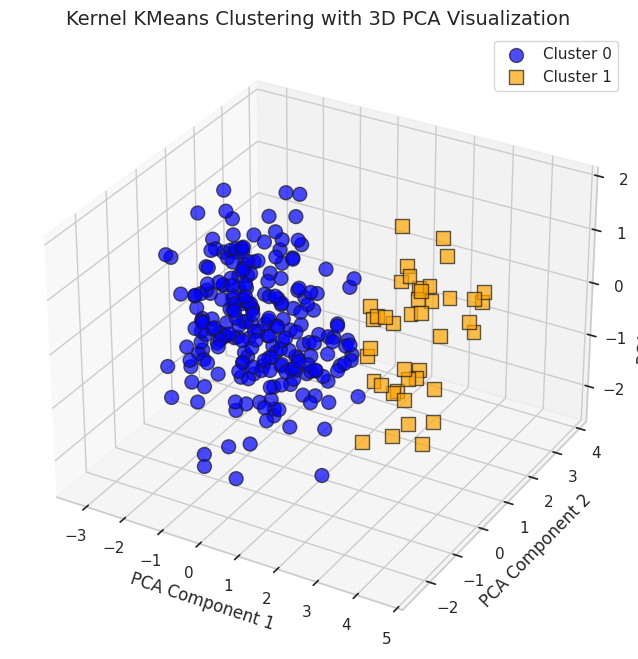

In [ ]:
# Step 1: Standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cleaned)  # Standardize input features

# Step 2: Apply Kernel KMeans (Using Spectral Clustering)
optimal_k = 2  # Set based on elbow method
kernel_kmeans = SpectralClustering(n_clusters=optimal_k, affinity='rbf', random_state=42)
clusters = kernel_kmeans.fit_predict(X_scaled)  # Clustering in transformed space

# Step 3: PCA Transformation (3D PCA for visualization)
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)  # Apply PCA AFTER KMeans
print("THIS VARIANCE VALUE SHOWS THAT THESE COMPONENTS ARE SOMEWHAT REPRESENTATIVE!: ", pca.explained_variance_ratio_)

# Convert to DataFrame
X_pca_df = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2', 'PCA3'])
X_pca_df['Cluster'] = clusters  # Add cluster labels

# Step 4: Create 3D figure
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
sns.set_style("whitegrid")

# Step 5: Assign colors and markers
colors = ['blue', 'orange', 'green', 'red', 'purple']  # Define colors for up to 5 clusters
markers = ['o', 's', 'D', '^', 'v']  # Different markers for clarity

# Step 6: Plot each cluster separately in 3D
for cluster in range(optimal_k):
    cluster_points = X_pca_df[X_pca_df['Cluster'] == cluster]

    ax.scatter(cluster_points['PCA1'], cluster_points['PCA2'], cluster_points['PCA3'],
               c=colors[cluster], marker=markers[cluster], label=f'Cluster {cluster}',
               edgecolors='k', alpha=0.7, s=100)

# Step 7: Formatting the 3D plot
ax.set_xlabel("PCA Component 1", fontsize=12)
ax.set_ylabel("PCA Component 2", fontsize=12)
ax.set_zlabel("PCA Component 3", fontsize=12)
ax.set_title("Kernel KMeans Clustering with 3D PCA Visualization", fontsize=14)
ax.legend()
plt.show()

### Supervised Learning: Kernel SVM

In [ ]:
processed_df['patient_status'].value_counts()

,count
patient_status,
AB,210
NO,100


In [ ]:
processed_df1 = pd.read_csv('processed.csv')
processed_df1

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,palvic_radius,spondylolisthesis_grade,patient_status
0,63.03,22.55,39.61,40.48,98.67,-0.25,AB
1,39.06,10.06,25.02,29.00,114.41,4.56,AB
2,68.83,22.22,50.09,46.61,105.99,-3.53,AB
3,69.30,24.65,44.31,44.64,101.87,11.21,AB
4,49.71,9.65,28.32,40.06,108.17,7.92,AB
...,...,...,...,...,...,...,...
305,47.90,13.62,36.00,34.29,117.45,-4.25,NO
306,53.94,20.72,29.22,33.22,114.37,-0.42,NO
307,61.45,22.69,46.17,38.75,125.67,-2.71,NO
308,45.25,8.69,41.58,36.56,118.55,0.21,NO


In [ ]:
# Load dataset
X = processed_df1.drop(['patient_status'], axis=1)
y = processed_df1['patient_status']
X

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,palvic_radius,spondylolisthesis_grade
0,63.03,22.55,39.61,40.48,98.67,-0.25
1,39.06,10.06,25.02,29.00,114.41,4.56
2,68.83,22.22,50.09,46.61,105.99,-3.53
3,69.30,24.65,44.31,44.64,101.87,11.21
4,49.71,9.65,28.32,40.06,108.17,7.92
...,...,...,...,...,...,...
305,47.90,13.62,36.00,34.29,117.45,-4.25
306,53.94,20.72,29.22,33.22,114.37,-0.42
307,61.45,22.69,46.17,38.75,125.67,-2.71
308,45.25,8.69,41.58,36.56,118.55,0.21


Cross-Validation Precision: 0.7591818796484111
Cross-Validation Recall: 0.770343137254902
Cross-Validation F1 Score: 0.7614917124243359

Test Set Evaluation:
Precision: 0.8514957264957265
Recall: 0.8916666666666666
F1 Score: 0.8617614269788183

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.83      0.90        42
           1       0.73      0.95      0.83        20

    accuracy                           0.87        62
   macro avg       0.85      0.89      0.86        62
weighted avg       0.89      0.87      0.87        62



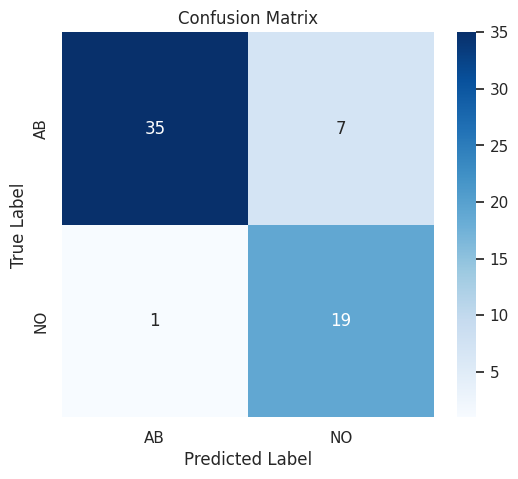

In [ ]:
# Train-Test Split (Before SMOTE)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Encode target variable
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# A pipeline (SMOTE -> Scaling -> Kernel PCA -> SVM)
pipeline = Pipeline([
    ('smote', SMOTE(sampling_strategy='auto', k_neighbors=11, random_state=42)),
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf', C=100, gamma=0.1, random_state=42))
])

# Cross-validation with Stratified K-Fold (Now SMOTE happens inside each fold)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
precision_scores = cross_val_score(pipeline, X_train, y_train_encoded, cv=cv, scoring='precision_macro')
recall_scores = cross_val_score(pipeline, X_train, y_train_encoded, cv=cv, scoring='recall_macro')
f1_scores = cross_val_score(pipeline, X_train, y_train_encoded, cv=cv, scoring='f1_macro')

# Print cross-validation results
print("Cross-Validation Precision:", np.mean(precision_scores))
print("Cross-Validation Recall:", np.mean(recall_scores))
print("Cross-Validation F1 Score:", np.mean(f1_scores))

# ---- Train Final Model on Full Resampled Training Data ----
# Apply SMOTE to the entire training set
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train_encoded)
# Feature Scaling (Fit on Train, Transform Both)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Train Final SVM Model
svm = SVC(kernel='rbf', C=100, gamma=0.05, random_state=42)
svm.fit(X_train_scaled, y_train_resampled)
# Make Predictions on Test Set
y_pred = svm.predict(X_test_scaled)

# Performance Metrics
print("\nTest Set Evaluation:")
print("Precision:", precision_score(y_test_encoded, y_pred, average='macro'))
print("Recall:", recall_score(y_test_encoded, y_pred, average='macro'))
print("F1 Score:", f1_score(y_test_encoded, y_pred, average='macro'))
print("\nClassification Report:\n", classification_report(y_test_encoded, y_pred))

# Confusion Matrix
plt.figure(figsize=(6, 5))
conf_matrix = confusion_matrix(y_test_encoded, y_pred, labels=[0, 1])
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()



### Other explorations

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


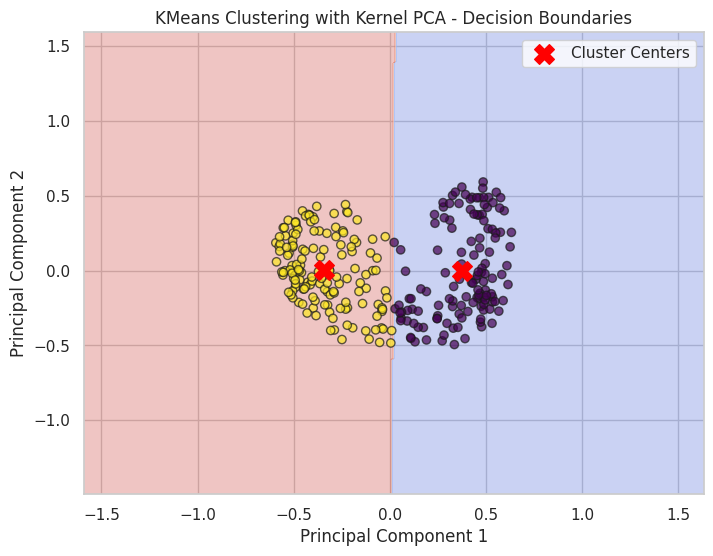

In [ ]:
# Step 1: Standardization
scaler = StandardScaler()
X_kpca_scaled = scaler.fit_transform(X_cleaned)  # Standardize input features

# Step 2: Kernel PCA Transformation (Cosine Kernel)
kpca = KernelPCA(n_components=2, kernel='rbf')
X_kpca = kpca.fit_transform(X_kpca_scaled)

# Convert to DataFrame
X_kpca_df = pd.DataFrame(X_kpca, columns=['KPCA1', 'KPCA2'])

# Step 3: Fit KMeans
optimal_k = 2  # Set based on elbow method
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_kpca_df)

# Step 4: Create Meshgrid for Contour Plot
x_min, x_max = X_kpca_df['KPCA1'].min() - 1, X_kpca_df['KPCA1'].max() + 1
y_min, y_max = X_kpca_df['KPCA2'].min() - 1, X_kpca_df['KPCA2'].max() + 1

x, y = np.meshgrid(np.linspace(x_min, x_max, 300),
                   np.linspace(y_min, y_max, 300))

xy = np.c_[x.ravel(), y.ravel()]  # Flatten meshgrid for predictions

# Step 5: Predict Cluster Labels for Each Point in Meshgrid
Z = kmeans.predict(xy)
Z = Z.reshape(x.shape)  # Reshape for contour plot

# Step 6: Plot Decision Boundaries
plt.figure(figsize=(8, 6))
plt.contourf(x, y, Z, cmap='coolwarm', alpha=0.3)  # Contour plot (decision regions)

# Step 7: Plot Data Points
plt.scatter(X_kpca_df['KPCA1'], X_kpca_df['KPCA2'], c=clusters, cmap='viridis', edgecolors='k', alpha=0.7)

# Step 8: Plot Cluster Centers
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, c='red', marker='X', label="Cluster Centers")

# Final Formatting
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("KMeans Clustering with Kernel PCA - Decision Boundaries")
plt.legend()
plt.show()
